In [1]:
"""This file contains functions for performing segmentation (and labeling) on
multi-track piano-rolls"""
%matplotlib inline
from IPython.display import Audio
import os
import sys
import json
import errno
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import msaf
from pypianoroll import Multitrack, Track

In [2]:
# Matplotlib
plt.rc('font', family='serif', size=6.0)
plt.rc('axes', titleweight='bold', labelweight='bold')
plt.rc('figure', dpi=600)

In [3]:
config = {}
config['lpd_root'] = "/home/salu133445/NAS/salu133445/lpd/lpd/lpd_cleansed/"
config['id_path'] = "/home/salu133445/NAS/salu133445/lpd/cleansed_ids.txt"
config['synth_root'] = ("/home/salu133445/NAS/salu133445/lpd/synthesized/"
                        "lpd_cleansed/")
config['id_lists_root'] = ("/home/salu133445/NAS/salu133445/git/musegan/"
                           "preprocessing/id_lists")
config['result_dir'] = "./results/"
# config['min_segment_len'] = 1  # measures

# File format
config['extension'] = 'png' # 'pdf', 'ps', 'eps', 'svg'

In [4]:
with open(config['id_path']) as f:
    id_md5 = {line.split()[1]: line.split()[0] for line in f}

def make_sure_path_exists(path):
    """Create intermidate directories if the path does not exist."""
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def get_npz_path(msd_id):
    """Given an MSD ID, return the path to the corresponding npz file."""
    return os.path.join(config['lpd_root'], msd_id_to_dirs(msd_id),
                        id_md5[msd_id] + '.npz')

def get_multitrack(msd_id):
    """Given an MSD ID, return the loaded multi-track piano-roll."""
    return Multitrack(get_npz_path(msd_id))

def get_synthesized_path(msd_id):
    """Given an MSD ID, return the path to the corresponding synthesized audio
    file."""
    return os.path.join(config['synth_root'], msd_id_to_dirs(msd_id),
                        id_md5[msd_id] + '.mp3')

def get_segmentation_path(msd_id):
    return os.path.join(CONFIG['result_dir'], msd_id_to_dirs(msd_id),
                        id_md5[msd_id] + '.json')

In [5]:
def visualization(fn):
    """Decorator for visualization functions."""
    def decorated(*args, **kwargs):
        returns = fn(*args, **kwargs)
        if 'size' not in kwargs:
            kwargs['size'] = (10, 3)
        returns[0].set_size_inches(kwargs['size'][0], kwargs['size'][1])
        if 'filename' in kwargs:
            if 'dpi' not in kwargs:
                kwargs['dpi'] = 1200
            if '.' in kwargs['filename']:
                filepath = os.path.join(config['result_dir'],
                                        "{}.{}".format(kwargs['filename'],
                                                       config['extension']))
            else:
                filepath = os.path.join(config['result_dir'],
                                        kwargs['filename'])
            plt.savefig(filepath, dpi=kwargs['dpi'], bbox_inches='tight')
        return returns
    return decorated

def visualize_multitrack(m, **kwargs):
    """Visualize a multi-track piano-roll."""
    bar_resolution = 4 * m.beat_resolution
    fig, axs = m.plot(preset='frame', grid='x')
    plt.minorticks_off()
    num_bar = m.tracks[0].pianoroll.shape[0] // bar_resolution
    xticks_major = bar_resolution * np.arange(0, num_bar)
    for ax in axs:
        ax.set_xticks(xticks_major)
    return fig, axs

@visualization
def visualize(m, **kwargs):
    """Visualize a multi-track piano-roll. See `visualize_multitrack()` for the
    documentation."""
    return visualize_multitrack(m, **kwargs)

In [6]:
make_sure_path_exists(config['result_dir'])
iterator = iter(id_md5.keys())

In [38]:
msd_id = next(iterator)
m = get_multitrack(msd_id)

In [39]:
# get_npz_path(next(iter(id_md5.keys())))
boundaries, labels = msaf.process(
    get_npz_path(msd_id), boundaries_id="sf", # labels_id=None,
    feature="mfcc", annot_beats=True, 
)
# Segmentation algorithms: {'vmo', 'cnmf', 'olda', 'foote', 'example', 'scluster', 'sf'}
# Label algorithms: {'vmo', 'cnmf', 'scluster', 'fmc2d'}
print("Number of segments:", len(boundaries))
print("Boundaries:", boundaries)
# print("Labels:", labels)

Number of segments: 10
Boundaries: [   0.        504.000504 1680.00168  2400.0024   3288.003288 4512.004512
 6504.006504 7224.007224 7560.00756  7584.007584]


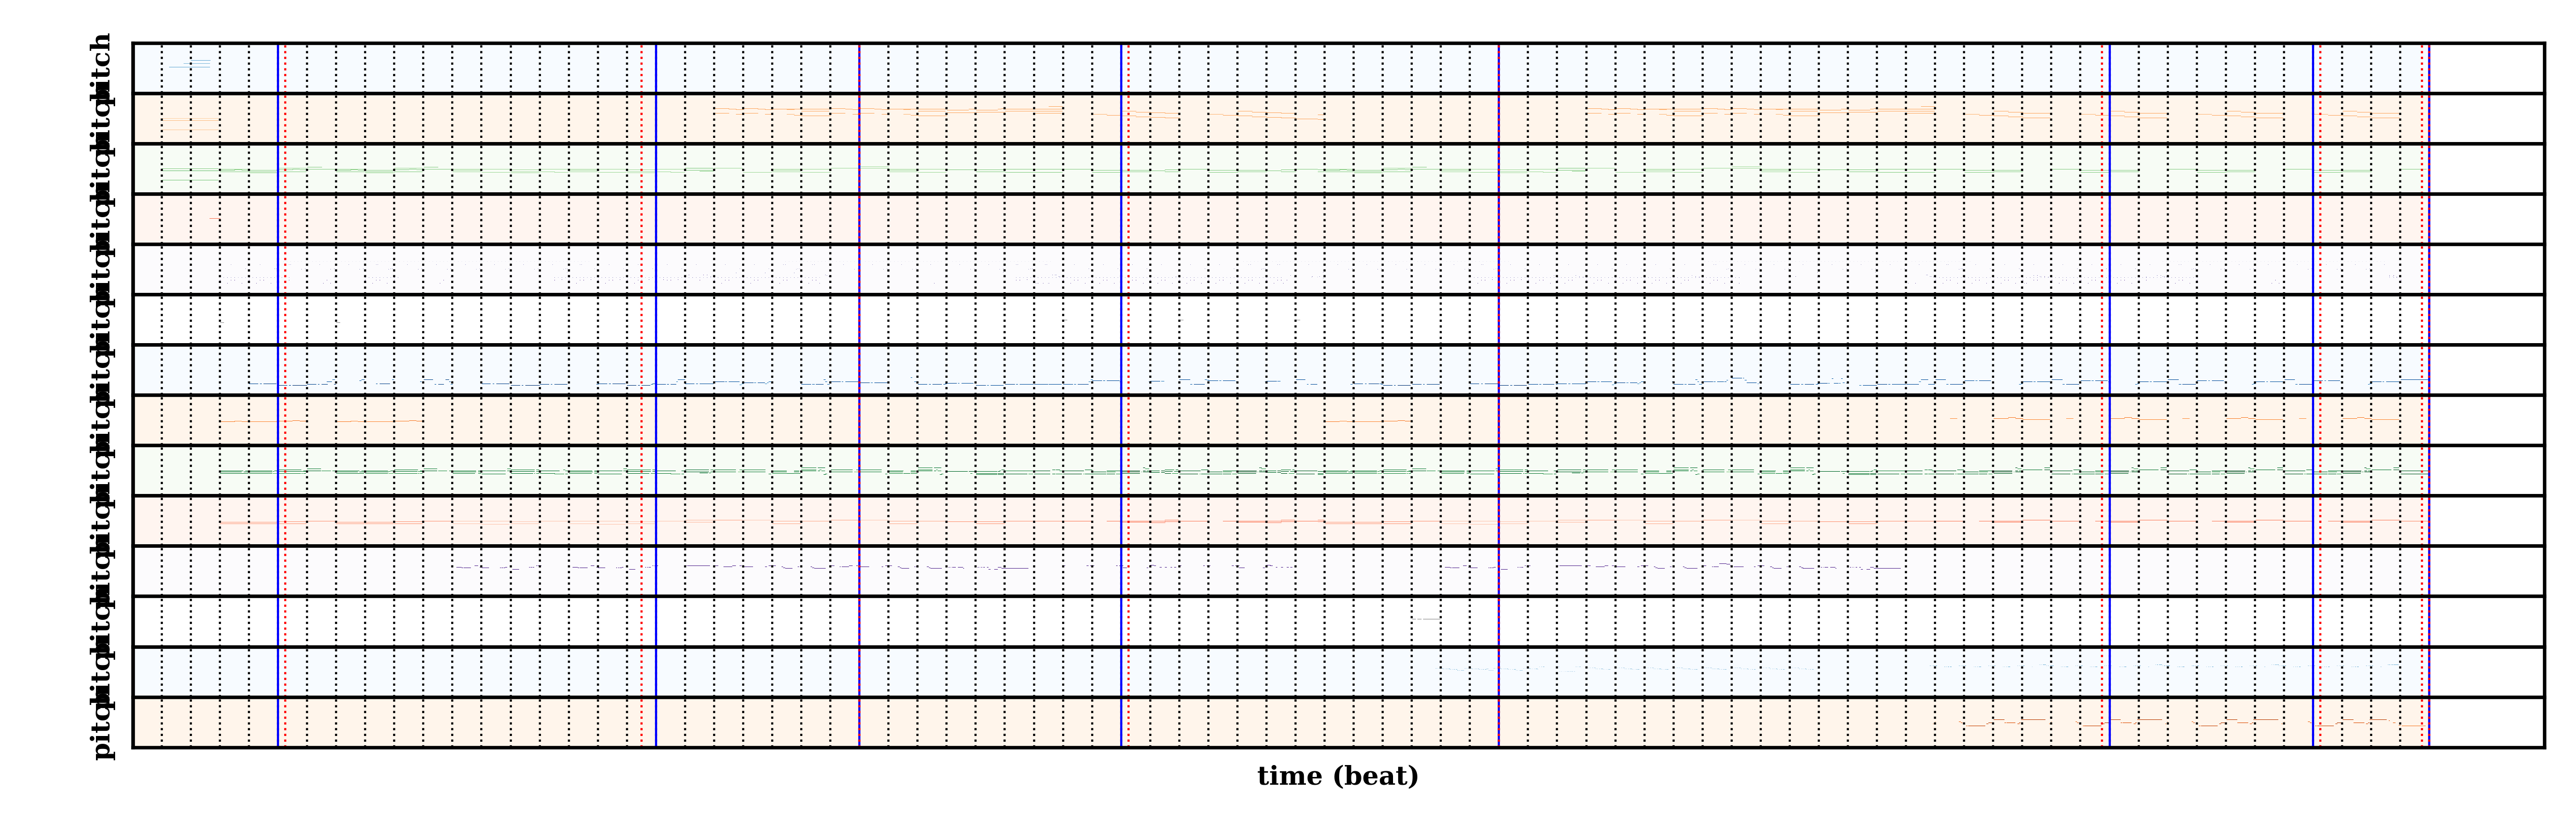

In [40]:
fig, axs = visualize(m)
for ax in axs:
    for boundary in boundaries:
        aligned = round(boundary * (m.tempo[0] / 60.) / 96) * 96
        ax.axvline(aligned, color='b', linewidth=.5)
        ax.axvline(boundary * (m.tempo[0] / 60.), color='r', linestyle=':', linewidth=.5)

In [10]:
# pm = m.to_pretty_midi()
# waveform = pm.fluidsynth()
# Audio(waveform, rate=44100)